In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import permutation_importance

In [4]:
def wrangle_data(filepath):

    # Load the dataset
    df = pd.read_csv(filepath)
    
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Clean 'price' column (remove 'Ksh' text, convert to int)
    df['price_in_ksh'] = df['price'].replace(r"[^\d]", "", regex=True).astype(int)

    # Extract numeric house size
    df['house_size_sqm'] = (
        df['house_size']
        .str.extract(r'(\d+\.?\d*)')
        .astype(float)
    )

    # Clean property type names
    df['propertytype'] = (
        df['propertytype']
        .str.strip()
        .str.title()
        .replace({'Townhuse': 'Townhouse'})
    )

    # Impute missing house sizes using group-wise median, fallback to global median
    df['house_size_sqm'] = df.groupby('propertytype')['house_size_sqm']\
        .transform(lambda x: x.fillna(x.median()))
    df['house_size_sqm'] = df['house_size_sqm'].fillna(df['house_size_sqm'].median())

    # Apply masks
    mask_valid_size = (df['house_size_sqm'] > 50) & (df['house_size_sqm'] < 500)
    mask_complete = df['bedroom'].notnull() & df['bathroom'].notnull()

    # Final dataframe
    df = df[mask_valid_size & mask_complete].copy()

    # Drop unused columns
    df = df.drop(columns=['price', 'house_size', 'land_size'], errors='ignore')

    # Reset index
    df.reset_index(drop=True, inplace=True)

    return df

In [5]:
df = wrangle_data("Downloads/Nairobi propertyprices - Sheet1.csv")
print(df.shape)
df.head()

(173, 6)


,propertytype,location,bedroom,bathroom,price_in_ksh,house_size_sqm
0,Townhouse,Runda,4.0,4.0,350000000,267.0
1,Townhouse,Kitisuru,5.0,5.0,80000000,267.0
2,Apartment,Kileleshwa,4.0,4.0,25500000,230.0
3,Townhouse,Runda,6.0,6.0,300000000,267.0
4,Townhouse,Runda,4.0,4.0,160000000,267.0


In [6]:
df.isnull().sum()

propertytype      0
location          0
bedroom           0
bathroom          0
price_in_ksh      0
house_size_sqm    0
dtype: int64

In [14]:
# Calculate average price by location
avg_price = df.groupby('location')['price_in_ksh'].mean().sort_values(ascending=False)
avg_price_millions = avg_price / 1_000_000  # convert to millions

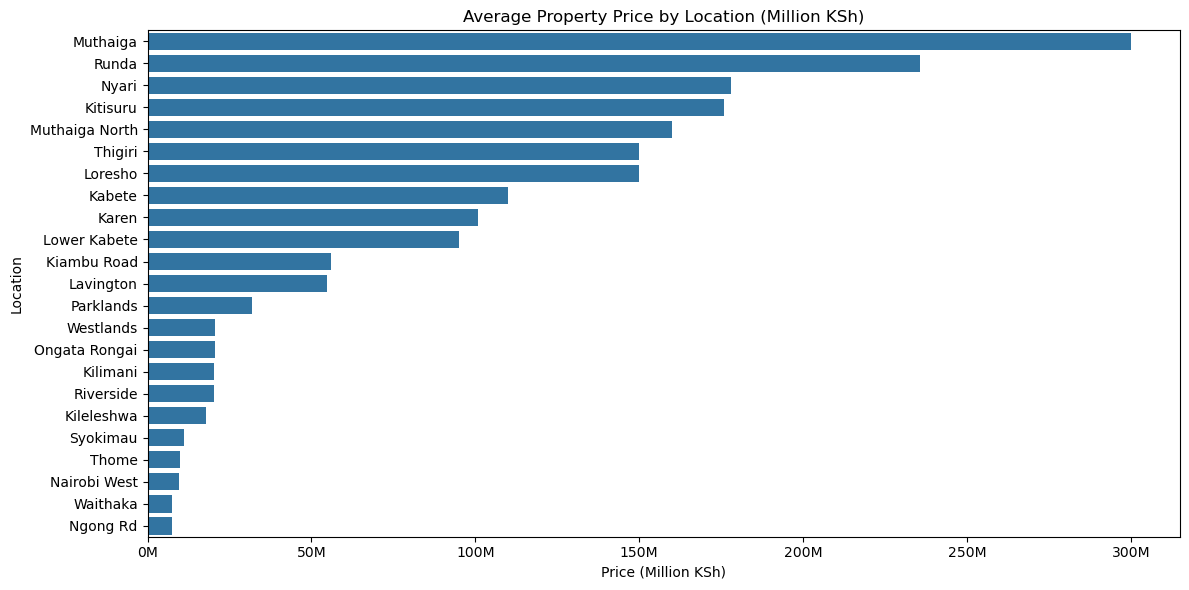

In [15]:
# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price_millions.values, y=avg_price_millions.index)

plt.title('Average Property Price by Location (Million KSh)')
plt.xlabel('Price (Million KSh)')
plt.ylabel('Location')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}M'))

plt.tight_layout()
plt.show()

Prices are highest in Muthaiga and surrounding zones like Runda, Nyari, and Kitisuru consistent with Nairobi's diplomatic and upper-income neighborhoods.
Interestingly, Karen despite its reputation as an affluent suburb — ranked lower than expected. This may be due to its broader mix of property types and lot sizes, or possible sampling variation in the dataset

In [16]:
df['propertytype'].value_counts()

propertytype
Apartment    98
Townhouse    75
Name: count, dtype: int64

In [18]:
# Calculate average price (in millions) by property type
avg_by_type_millions = df.groupby('propertytype')['price_in_ksh'].mean().sort_values() / 1_000_000

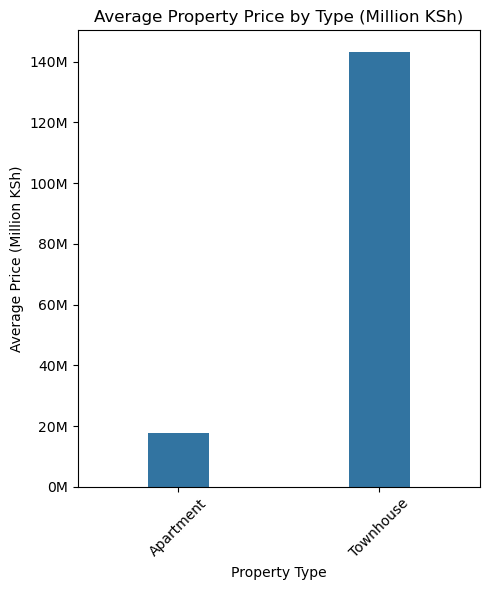

In [19]:
plt.figure(figsize=(5, 6))  

sns.barplot(
    x=avg_by_type_millions.index,
    y=avg_by_type_millions.values,
    width=0.3  
)

plt.title('Average Property Price by Type (Million KSh)')
plt.xlabel('Property Type')
plt.ylabel('Average Price (Million KSh)')
plt.xticks(rotation=45)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}M'))

plt.tight_layout()
plt.show()


Although apartments are the most frequently listed property type, townhouses command significantly higher average prices - likely reflecting their larger size and more premium positioning in Nairobi’s housing market.

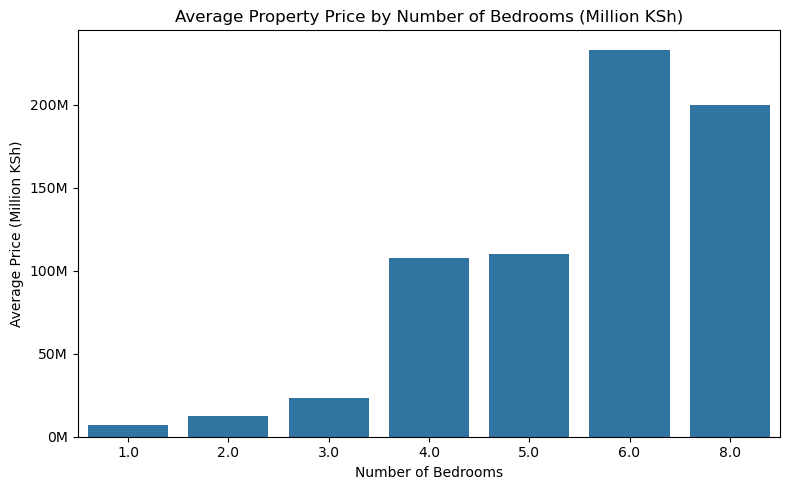

In [20]:
# Average price by number of bedrooms
avg_price_bedroom = df.groupby('bedroom')['price_in_ksh'].mean().sort_index()
avg_price_bedroom_millions = avg_price_bedroom / 1_000_000

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_price_bedroom_millions.index, y=avg_price_bedroom_millions.values)

plt.title('Average Property Price by Number of Bedrooms (Million KSh)')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Price (Million KSh)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}M'))

plt.tight_layout()
plt.show()

As expected, property prices increase with bedroom count. However, the price difference between 4- and 5-bedroom homes is minimal, while 6-bedroom homes show a significant price jump — possibly reflecting high-end listings. Interestingly, 8-bedroom homes appear slightly less expensive than 6-bedroom ones, which may suggest location or design tradeoffs at that size.

In [21]:
df['bedroom'].value_counts().sort_index()

bedroom
1.0    10
2.0    44
3.0    31
4.0    43
5.0    31
6.0     9
8.0     5
Name: count, dtype: int64

Most listings are clustered between 2–5 bedrooms, with 2-bedroom homes being the most common. Larger homes (6–8 bedrooms) are rare, and their average prices may reflect a small number of luxury properties rather than a consistent trend.

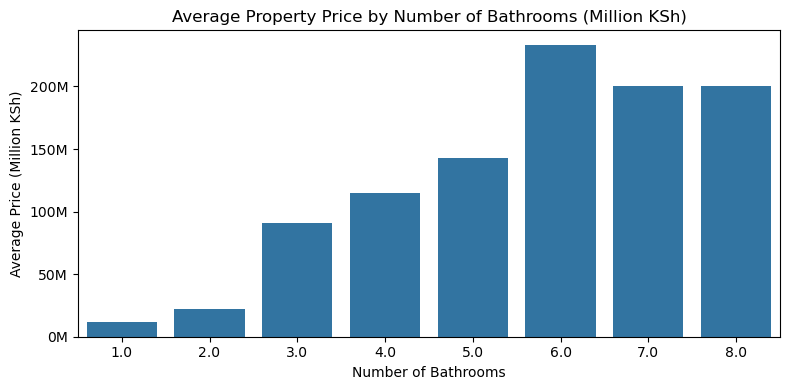

In [22]:
# Average price by number of bathrooms
avg_price_bath = df.groupby('bathroom')['price_in_ksh'].mean().sort_index()
avg_price_bath_millions = avg_price_bath / 1_000_000

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=avg_price_bath_millions.index, y=avg_price_bath_millions.values)

plt.title('Average Property Price by Number of Bathrooms (Million KSh)')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Average Price (Million KSh)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.0f}M'))

plt.tight_layout()
plt.show()

As bathroom count increases, so does average price — up to 6 bathrooms. Beyond that, the trend flattens or dips, possibly due to a small number of outlier listings or location tradeoffs.

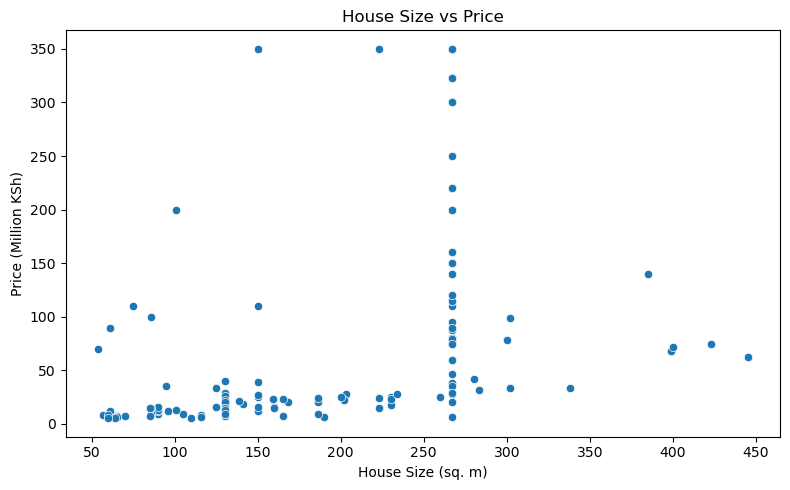

In [23]:
# Price vs House Size (Scatter Plot)
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=df['house_size_sqm'],
    y=df['price_in_ksh'] / 1_000_000
)

plt.title('House Size vs Price')
plt.xlabel('House Size (sq. m)')
plt.ylabel('Price (Million KSh)')
plt.tight_layout()
plt.show()

There’s a positive relationship between house size and price, but it’s weak. Some small homes are extremely expensive, likely due to location or luxury finishes. While larger homes tend to be more expensive on average, the scatter shows that house size alone doesn’t fully explain price variation.

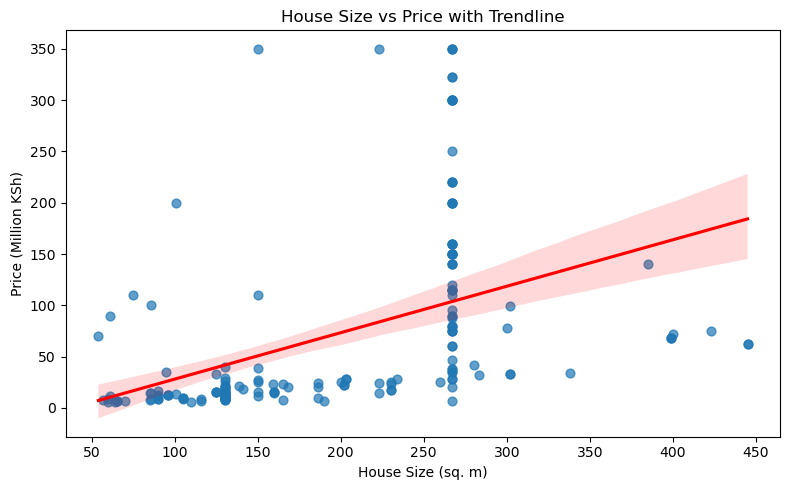

In [24]:
# regression trendline
plt.figure(figsize=(8, 5))
sns.regplot(
    x='house_size_sqm',
    y=df['price_in_ksh'] / 1_000_000,  # convert to millions
    data=df,
    scatter_kws={'s': 40, 'alpha': 0.7},
    line_kws={'color': 'red'}
)

plt.title('House Size vs Price with Trendline')
plt.xlabel('House Size (sq. m)')
plt.ylabel('Price (Million KSh)')
plt.tight_layout()
plt.show()

The line shows a very weak positive relationship as house size increases, price tends to rise slightly, but not consistently. Some small houses are highly priced, likely due to location or luxury features, while some large homes are relatively affordable. The price range stretches from about KSh 6 million to over KSh 150 million, with most house sizes falling between 50 and 450 square meters.

This suggests that house size alone doesn't strongly determine property value in Nairobi. Other factors, like neighborhood and property type, likely play a bigger role.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   propertytype    173 non-null    object 
 1   location        173 non-null    object 
 2   bedroom         173 non-null    float64
 3   bathroom        173 non-null    float64
 4   price_in_ksh    173 non-null    int32  
 5   house_size_sqm  173 non-null    float64
dtypes: float64(3), int32(1), object(2)
memory usage: 7.6+ KB


In [45]:
y = np.log1p(df['price_in_ksh'])  # log(1 + price)
X = df.drop(columns='price_in_ksh')

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# In case we need actual price later
y_test_actual = np.expm1(y_test)

In [62]:
# Categorical columns
cat_cols = ['propertytype', 'location']

# Updated preprocessor: sparse=False
preprocessor_dense = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ],
    remainder='passthrough'
)

In [50]:
# Baseline prediction: mean of training target
y_pred_baseline = np.full_like(y_test, y_train.mean())

# Reverse log for evaluation
y_pred_baseline_actual = np.expm1(y_pred_baseline)
y_test_actual = np.expm1(y_test)

# Compute RMSE
rmse_baseline = mean_squared_error(y_test_actual, y_pred_baseline_actual, squared=False)

# Compute mean actual price for context
mean_actual_price = y_test_actual.mean()
rmse_pct = (rmse_baseline / mean_actual_price) * 100

print(f"Baseline RMSE: {rmse_baseline:,.0f} KSh")
print(f"Baseline RMSE as % of mean price: {rmse_pct:.2f}%")

Baseline RMSE: 98,511,527 KSh
Baseline RMSE as % of mean price: 132.51%


C:\Users\B\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [65]:
# Create pipeline
tree_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    # Add a step to convert sparse matrix to dense array
    ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x)),
    ('regressor', HistGradientBoostingRegressor(random_state=42))
])

# Train
tree_model.fit(X_train, y_train)

# Predict
y_pred_log = tree_model.predict(X_test)
y_pred_actual = np.expm1(y_pred_log)

# Evaluate
rmse = mean_squared_error(y_test_actual, y_pred_actual, squared=False)
rmse_pct = (rmse / y_test_actual.mean()) * 100

print(f"Tree Model RMSE: {rmse:,.0f} KSh")
print(f"Tree Model RMSE as % of mean price: {rmse_pct:.2f}%")

Tree Model RMSE: 69,098,072 KSh
Tree Model RMSE as % of mean price: 92.94%


C:\Users\B\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [70]:
# Fit preprocessor separately on the training data
X_train_transformed = tree_model.named_steps['preprocessing'].fit_transform(X_train)

# Now get the feature names
ohe = tree_model.named_steps['preprocessing'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(cat_cols)
all_features_transformed = list(cat_features) + numeric_cols

In [71]:
# Run permutation importance
result = permutation_importance(
    tree_model, X_test, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

# Check how many features were returned
n_features_model_used = len(result.importances_mean)

# Use only matching names
feature_names_used = all_features_transformed[:n_features_model_used]

# Build Series
importance_scores = pd.Series(result.importances_mean, index=feature_names_used)
importance_scores = importance_scores.sort_values(ascending=False)

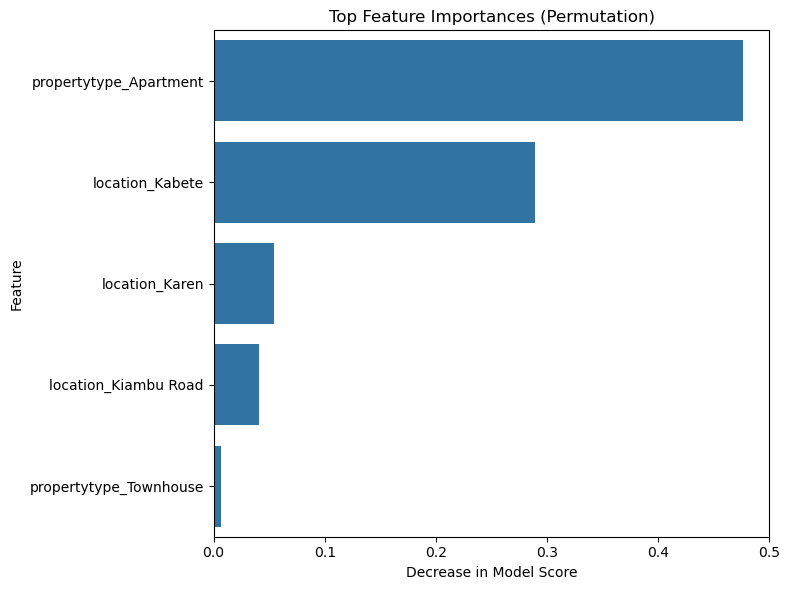

In [72]:
plt.figure(figsize=(8, 6))
sns.barplot(x=importance_scores.values[:10], y=importance_scores.index[:10])
plt.title("Top Feature Importances (Permutation)")
plt.xlabel("Decrease in Model Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

This suggests that property type and location are the most important drivers of price in this dataset — more than attributes like number of bedrooms, bathrooms, or house size.